# <b>ECON 484 FINAL PROJECT</b>
#### Notebook produced by Seth Peterson

In [1]:
# USED TO GENERATE THE MODEL FOR THE BOOK COMPARER CLASS, and
# USED TO GENERATE THE CROSSWALK BETWEEN THE NYT AND THE GOODREADS/ SPL

# <b>SECTION 0</b>: Setting Up Development Environment

In [2]:
import pandas as pd

# Book Cleaner is a proprietary class included in the repo
# Please ensure that you have the class in the same directory as this notebook
from clean_data.book_cleaner import BookCleaner


# You may need to install the following packages
import jellyfish as jf
import pylcs

# Standard ML packages
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Warning filters
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')

# <b> Section 1 </b> - Load and Clean the Data

In [3]:
df = pd.read_csv('training_set.csv')

# What does BookCleaner do?
# To boot, we remove all non-alphabet characters in a string. This will involve spaces too, but that comes later.
#
# We also want to remove all far- too common articles and other ‘filler words’
# ['a ', 'an ', 'the ', 'and ', 'nor ', 'but ', 'so ', 'or ', 'yet ', 'this ', 'that ', 'these ', 'those ', 'by ', \
# 'is ', 'be ', 'are ', 'am ', 'was ', 'were ', 'have ', 'has ', 'had ', 'his ', 'her ', 'he ', 'she ', 'of ']
#
# We also remove all book and publisher specific words. We reason these don’t impact the uniqueness of the data
# Ie, “Penguin” is likely the same publisher as “Penguin Publisher”
# [' novel', ' movie', ' book', ' memoir', ' edition',  ' publisher', ' books', ' member',  'novel ', 'movie ', 'book ', 'memoir’, 'edition ',  'publisher ', 'books ', 'member '] 
#
# Of course, finally we strip spaces from strings to normalize the text.

bc = BookCleaner(df)
cdf = bc.get_clean_df()

In [4]:
cdf.head(5)

is_match  publish_year_a      isbn_a  publish_year_b      isbn_b   
0         1            2013  0399159347            2020  0425274861  \
1         1            2015  1594633665            2015  1594633665   
2         1            2006  074324754X            2006  074324754X   
3         1            2013  0385537859            2016  1101972971   
4         1            2011  030788743X            2012  0307887448   

  cleaned_author_a cleaned_author_b             cleaned_title_a   
0    lianemoriarty    lianemoriarty         the husbands secret  \
1     paulahawkins     paulahawkins       the girl on the train   
2   jeannettewalls   jeannettewalls  the glass castle  a memoir   
3         danbrown         danbrown            inferno  a novel   
4      ernestcline      ernestcline            ready player one   

                                     cleaned_title_b   
0  liane moriarty collection 8 books set the hypn...  \
1                              the girl on the train   
2                          the glass castle a memoir   
3         inferno movie tiein edition robert langdon   
4                           ready player one a novel   

                                 cleaned_publisher_a cleaned_publisher_b   
0  amy einhorn books published by g p putnams son...             penguin  \
1      riverhead books a member of penguin group usa     riverhead books   
2                                           scribner            scribner   
3                                          doubleday              anchor   
4                                   crown publishers    ballantine books   

  removed_all_title_a                                removed_all_title_b   
0      husbandssecret  lianemoriartycollection8ssethypnotistslovestor...  \
1         girlontrain                                        girlontrain   
2         glasscastle                                        glasscastle   
3             inferno                          infernotieinrobertlangdon   
4      readyplayerone                                     readyplayerone   

                             removed_all_publisher_a removed_all_publisher_b  
0  amyeinhornspublishedgpputnamssonspenguingroupu...                 penguin  
1                          riverheadspenguingroupusa              riverheads  
2                                           scribner                scribner  
3                                          doubleday                  anchor  
4                                             crowns             ballantines

# <b> SECTION 2:</b> Create a Numeric DataFrame for Testing

In [5]:
# Goal: Create a df of all numeric values only

# We use the following metrics to compare strings:
# 1. Levenshtein Distance
# 2. Damerau-Levenshtein Distance
# 3. Hamming Distance
# 4. Jaro Similarity
# 5. Edit Distance

# Each are similar in that they are all string comparison metrics, but they are all different in their own way

# The numeric_df will be used to train the model

def gen_numeric_df(cdf):
    df = cdf.copy()

    colHeaders = ['cleaned_author_', 'cleaned_title_', 'cleaned_publisher_', \
                  'removed_all_title_', 'removed_all_publisher_']

    numeric_df = df[['is_match']]

    numeric_df['isbn_a'] = df['isbn_a']
    numeric_df['isbn_b'] = df['isbn_b']

    numeric_df['publish_year_delta'] = abs(df['publish_year_b'] - df['publish_year_a'])

    for col in colHeaders:
        col_a = col + 'a'
        col_b = col + 'b'

        print('Generating for col', col, '                  ',flush=True, end='\r')
        numeric_df[col+'levenshtein'] = df.apply(lambda row : jf.levenshtein_distance(row[col_a], row[col_b]), axis = 1)
        numeric_df[col+'damerau'] = df.apply(lambda row : jf.damerau_levenshtein_distance(row[col_a], row[col_b]), axis = 1)
        numeric_df[col+'hamming'] = df.apply(lambda row : jf.hamming_distance(row[col_a], row[col_b]), axis = 1)
        numeric_df[col+'jaro'] = df.apply(lambda row : jf.jaro_similarity(row[col_a], row[col_b]), axis = 1)
        numeric_df[col+'edit_dist'] = df.apply(lambda row : pylcs.edit_distance(row[col_a], row[col_b]), axis = 1)
        
    return numeric_df

In [6]:
# Takes about 1.5 minutes to run on a decent laptop
n_df = gen_numeric_df(cdf)

In [7]:
n_df = n_df * 1 # NECESSARY! Turns bool into int

In [8]:
n_df.head(3)

is_match      isbn_a      isbn_b  publish_year_delta   
0         1  0399159347  0425274861                   7  \
1         1  1594633665  1594633665                   0   
2         1  074324754X  074324754X                   0   

   cleaned_author_levenshtein  cleaned_author_damerau  cleaned_author_hamming   
0                           0                       0                       0  \
1                           0                       0                       0   
2                           0                       0                       0   

   cleaned_author_jaro  cleaned_author_edit_dist  cleaned_title_levenshtein   
0                  1.0                         0                        167  \
1                  1.0                         0                          0   
2                  1.0                         0                          1   

   ...  removed_all_title_levenshtein  removed_all_title_damerau   
0  ...                            137                        137  \
1  ...                              0                          0   
2  ...                              0                          0   

   removed_all_title_hamming  removed_all_title_jaro   
0                        151                0.468006  \
1                          0                1.000000   
2                          0                1.000000   

   removed_all_title_edit_dist  removed_all_publisher_levenshtein   
0                          137                                 43  \
1                            0                                 15   
2                            0                                  0   

   removed_all_publisher_damerau  removed_all_publisher_hamming   
0                             43                             50  \
1                             15                             15   
2                              0                              0   

   removed_all_publisher_jaro  removed_all_publisher_edit_dist  
0                    0.570476                               43  
1                    0.800000                               15  
2                    1.000000                                0  

[3 rows x 29 columns]

# <b> SECTION 3:</b> Reducing the Y=0 Observations

Do the math– 984 observations in our comparison set, matched against 10,000 observations in our master sheet, result in 9,840,000 total permutations.


If we had a naive estimator that only answered “No” for every match of books it encountered, it would have a training accuracy of (9,840,000 - 328) / 9,844,000: 99.96% accuracy. That seems great, but the estimator is absolutely useless if it doesn’t find any matches!


To attempt to combat this, we first drop our total amount of “not matches” in our dataset down to 400,000 using random-selection. Still not awesome, though; our ‘all-no’ estimator would have an accuracy of (400328 - 328) / 400328 = 99.92%. Still not great.

Thus, we must further reduce the number of observations

In [9]:
# Let's compute some summary statistics for each column we deem interesting
# This is somewhat arbitrary, but we want to see if there are any outliers that we can immediately remove

interesting_cols = ['removed_all_title_hamming', 'removed_all_title_levenshtein', 'removed_all_title_jaro', 'removed_all_publisher_hamming', 'removed_all_publisher_levenshtein', 'removed_all_publisher_jaro', 'cleaned_author_hamming', 'cleaned_author_jaro', 'cleaned_author_damerau']

In [10]:
# Summary statistics for all matches
n_df[n_df['is_match'] ==1][interesting_cols].describe()

removed_all_title_hamming  removed_all_title_levenshtein   
count                 328.000000                     328.000000  \
mean                   21.557927                      18.493902   
std                    31.548269                      27.867861   
min                     0.000000                       0.000000   
25%                     0.000000                       0.000000   
50%                    12.000000                      12.000000   
75%                    25.500000                      21.000000   
max                   151.000000                     138.000000   

       removed_all_title_jaro  removed_all_publisher_hamming   
count              328.000000                     328.000000  \
mean                 0.852452                      10.155488   
std                  0.149171                       9.774377   
min                  0.405570                       0.000000   
25%                  0.763689                       0.000000   
50%                  0.854573                       9.000000   
75%                  1.000000                      14.000000   
max                  1.000000                      66.000000   

       removed_all_publisher_levenshtein  removed_all_publisher_jaro   
count                         328.000000                  328.000000  \
mean                            8.719512                    0.737664   
std                             8.356029                    0.223803   
min                             0.000000                    0.000000   
25%                             0.000000                    0.529762   
50%                             7.000000                    0.788889   
75%                            12.000000                    1.000000   
max                            53.000000                    1.000000   

       cleaned_author_hamming  cleaned_author_jaro  cleaned_author_damerau  
count              328.000000           328.000000              328.000000  
mean                 2.484756             0.946538                1.801829  
std                  5.457067             0.126558                4.167780  
min                  0.000000             0.435897                0.000000  
25%                  0.000000             1.000000                0.000000  
50%                  0.000000             1.000000                0.000000  
75%                  0.000000             1.000000                0.000000  
max                 41.000000             1.000000               34.000000

In [11]:
# Summary statistics for all non-matches
n_df[n_df['is_match'] == 0][interesting_cols].describe()

removed_all_title_hamming  removed_all_title_levenshtein   
count              400000.000000                  400000.000000  \
mean                   40.460385                      35.329885   
std                    29.074570                      26.157699   
min                     0.000000                       0.000000   
25%                    21.000000                      19.000000   
50%                    32.000000                      28.000000   
75%                    48.000000                      41.000000   
max                   169.000000                     163.000000   

       removed_all_title_jaro  removed_all_publisher_hamming   
count           400000.000000                  400000.000000  \
mean                 0.510235                      15.912522   
std                  0.082133                       7.261276   
min                  0.000000                       0.000000   
25%                  0.467949                      11.000000   
50%                  0.517589                      14.000000   
75%                  0.561836                      19.000000   
max                  1.000000                      90.000000   

       removed_all_publisher_levenshtein  removed_all_publisher_jaro   
count                      400000.000000               400000.000000  \
mean                           13.841447                    0.490879   
std                             6.255709                    0.126299   
min                             0.000000                    0.000000   
25%                            10.000000                    0.438889   
50%                            13.000000                    0.500712   
75%                            17.000000                    0.553114   
max                            86.000000                    1.000000   

       cleaned_author_hamming  cleaned_author_jaro  cleaned_author_damerau  
count           400000.000000        400000.000000           400000.000000  
mean                13.315988             0.480367               11.899297  
std                  3.753120             0.112090                3.181637  
min                  0.000000             0.000000                0.000000  
25%                 11.000000             0.435897               10.000000  
50%                 13.000000             0.490741               12.000000  
75%                 15.000000             0.543651               13.000000  
max                 45.000000             1.000000               45.000000

In [12]:
# Given all the above, we can see that there are some outliers that we can remove
# This mask is critically important but also highly subjective
mask = (n_df['removed_all_title_hamming'] <= 28) & (n_df['removed_all_title_levenshtein'] <= 28) & (n_df['removed_all_title_jaro'] >= .4) & (n_df['removed_all_publisher_hamming'] <= 11) & (n_df['removed_all_publisher_levenshtein'] <= 13) & (n_df['cleaned_author_hamming'] <= 11) & (n_df['cleaned_author_jaro'] >= .5) & (n_df['cleaned_author_damerau'] <= 9)
n_df[mask].describe()

is_match  publish_year_delta  cleaned_author_levenshtein   
count  5863.000000         5863.000000                 5863.000000  \
mean      0.022514            8.034453                    7.782364   
std       0.148361            7.535598                    1.751945   
min       0.000000            0.000000                    0.000000   
25%       0.000000            3.000000                    7.000000   
50%       0.000000            6.000000                    8.000000   
75%       0.000000           11.000000                    9.000000   
max       1.000000           90.000000                   10.000000   

       cleaned_author_damerau  cleaned_author_hamming  cleaned_author_jaro   
count             5863.000000             5863.000000          5863.000000  \
mean                 7.757291                8.903804             0.591973   
std                  1.741854                2.075089             0.094323   
min                  0.000000                0.000000             0.500000   
25%                  7.000000                8.000000             0.533333   
50%                  8.000000                9.000000             0.567100   
75%                  9.000000               10.000000             0.614815   
max                  9.000000               11.000000             1.000000   

       cleaned_author_edit_dist  cleaned_title_levenshtein   
count               5863.000000                5863.000000  \
mean                   7.782364                  23.000512   
std                    1.751945                   8.439248   
min                    0.000000                   0.000000   
25%                    7.000000                  17.000000   
50%                    8.000000                  23.000000   
75%                    9.000000                  28.000000   
max                   10.000000                  53.000000   

       cleaned_title_damerau  cleaned_title_hamming  ...   
count            5863.000000            5863.000000  ...  \
mean               22.966741              27.526693  ...   
std                 8.436777              10.148636  ...   
min                 0.000000               0.000000  ...   
25%                17.000000              21.000000  ...   
50%                23.000000              27.000000  ...   
75%                28.000000              34.000000  ...   
max                53.000000              83.000000  ...   

       removed_all_title_levenshtein  removed_all_title_damerau   
count                    5863.000000                5863.000000  \
mean                       15.666212                  15.642845   
std                         5.032236                   5.030241   
min                         0.000000                   0.000000   
25%                        12.000000                  12.000000   
50%                        16.000000                  16.000000   
75%                        20.000000                  20.000000   
max                        28.000000                  28.000000   

       removed_all_title_hamming  removed_all_title_jaro   
count                5863.000000             5863.000000  \
mean                   17.974586                0.520114   
std                     5.870071                0.089609   
min                     0.000000                0.400513   
25%                    14.000000                0.461988   
50%                    18.000000                0.510185   
75%                    23.000000                0.555556   
max                    28.000000                1.000000   

       removed_all_title_edit_dist  removed_all_publisher_levenshtein   
count                  5863.000000                        5863.000000  \
mean                     15.666212                           7.845301   
std                       5.032236                           2.150460   
min                       0.000000                           0.000000   
25%                      12.000000                           7.000

In [13]:
# After filtering, we have just 5,863 rows with which to train our model
subset_df = n_df[mask].reset_index(drop = True)
subset_df.head(3)

is_match      isbn_a      isbn_b  publish_year_delta   
0         1  074324754X  074324754X                   0  \
1         1  0385537859  1101972971                   3   
2         1  030788743X  0307887448                   1   

   cleaned_author_levenshtein  cleaned_author_damerau  cleaned_author_hamming   
0                           0                       0                       0  \
1                           0                       0                       0   
2                           0                       0                       0   

   cleaned_author_jaro  cleaned_author_edit_dist  cleaned_title_levenshtein   
0                  1.0                         0                          1  \
1                  1.0                         0                         28   
2                  1.0                         0                          8   

   ...  removed_all_title_levenshtein  removed_all_title_damerau   
0  ...                              0                          0  \
1  ...                             18                         18   
2  ...                              0                          0   

   removed_all_title_hamming  removed_all_title_jaro   
0                          0                    1.00  \
1                         18                    0.76   
2                          0                    1.00   

   removed_all_title_edit_dist  removed_all_publisher_levenshtein   
0                            0                                  0  \
1                           18                                  9   
2                            0                                  9   

   removed_all_publisher_damerau  removed_all_publisher_hamming   
0                              0                              0  \
1                              9                              9   
2                              9                             11   

   removed_all_publisher_jaro  removed_all_publisher_edit_dist  
0                    1.000000                                0  
1                    0.425926                                9  
2                    0.419192                                9  

[3 rows x 29 columns]

# <b> SECTION 4: </b> IT'S TIME FOR MACHINE LEARNING

In [14]:
# Create our outcome variable, y
y = subset_df['is_match']
y

0       1
1       1
2       1
3       1
4       1
       ..
5858    0
5859    0
5860    0
5861    0
5862    0
Name: is_match, Length: 5863, dtype: int64

In [15]:
subset_df
# See, I told you we have 5,863 rows. Lol

is_match      isbn_a      isbn_b  publish_year_delta   
0            1  074324754X  074324754X                   0  \
1            1  0385537859  1101972971                   3   
2            1  030788743X  0307887448                   1   
3            1  0590353403  059035342X                   0   
4            1  1250012570  1250012570                   0   
...        ...         ...         ...                 ...   
5858         0  141690817X  0590846280                   9   
5859         0  0345479726  0385542690                  11   
5860         0  1250086612  0735212163                   0   
5861         0  0545298393  014241543X                   1   
5862         0  0375867643  0062392174                   5   

      cleaned_author_levenshtein  cleaned_author_damerau   
0                              0                       0  \
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
5858                           9                       9   
5859                           7                       7   
5860                           9                       9   
5861                           6                       6   
5862                           9                       9   

      cleaned_author_hamming  cleaned_author_jaro  cleaned_author_edit_dist   
0                          0             1.000000                         0  \
1                          0             1.000000                         0   
2                          0             1.000000                         0   
3                          0             1.000000                         0   
4                          0             1.000000                         0   
...                      ...                  ...                       ...   
5858                      11             0.592593                         9   
5859                      10             0.550000                         7   
5860                      11             0.516667                         9   
5861                      11             0.626263                         6   
5862                      10             0.590741                         9   

      cleaned_title_levenshtein  ...  removed_all_title_levenshtein   
0                             1  ...                              0  \
1                            28  ...                             18   
2                             8  ...                              0   
3                             0  ...                              0   
4                             0  ...                              0   
...                         ...  ...                            ...   
5858                         22  ...                             22   
5859                         28  ...                             17   
5860                         23  ...                             13   
5861                         13  ...                              8   
5862                         19  ...                             13   

      removed_all_title_damerau  removed_all_title_hamming   
0                             0                          0  \
1                            18                         18   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
5858                         22                         26   
5859                         17                         20   
5860                         13                         14   
5861                          8                          9   
5862                         13                         

In [16]:
# MAKE SURE TO **NOT** USE THE ISBN FOR ANY ANALYSIS!!!!!
X = subset_df.drop(['is_match', 'isbn_a', 'isbn_b'], axis = 1)
X.describe()
X

publish_year_delta  cleaned_author_levenshtein  cleaned_author_damerau   
0                      0                           0                       0  \
1                      3                           0                       0   
2                      1                           0                       0   
3                      0                           0                       0   
4                      0                           0                       0   
...                  ...                         ...                     ...   
5858                   9                           9                       9   
5859                  11                           7                       7   
5860                   0                           9                       9   
5861                   1                           6                       6   
5862                   5                           9                       9   

      cleaned_author_hamming  cleaned_author_jaro  cleaned_author_edit_dist   
0                          0             1.000000                         0  \
1                          0             1.000000                         0   
2                          0             1.000000                         0   
3                          0             1.000000                         0   
4                          0             1.000000                         0   
...                      ...                  ...                       ...   
5858                      11             0.592593                         9   
5859                      10             0.550000                         7   
5860                      11             0.516667                         9   
5861                      11             0.626263                         6   
5862                      10             0.590741                         9   

      cleaned_title_levenshtein  cleaned_title_damerau  cleaned_title_hamming   
0                             1                      1                      9  \
1                            28                     28                     34   
2                             8                      8                      8   
3                             0                      0                      0   
4                             0                      0                      0   
...                         ...                    ...                    ...   
5858                         22                     22                     31   
5859                         28                     28                     36   
5860                         23                     23                     28   
5861                         13                     13                     15   
5862                         19                     19                     20   

      cleaned_title_jaro  ...  removed_all_title_levenshtein   
0               0.973846  ...                              0  \
1               0.698214  ...                             18   
2               0.888889  ...                              0   
3               1.000000  ...                              0   
4               1.000000  ...                              0   
...                  ...  ...                            ...   
5858            0.650277  ...                             22   
5859            0.534259  ...                             17   
5860            0.645743  ...                             13   
5861            0.562963  ...                              8   
5862            0.570048  ...                             13   

      removed_all_title_damerau  removed_all_title_hamming   
0                             0                          0  \
1                            18                         18   
2                             0                          0   
3                             0                          0   
4                             0             

In [17]:
# STANDARD SCALE THE X.
# Prepping Data
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=42)

Pure Supervised Strategies

In [18]:
# Linear Models
#from sklearn.Linear_Model import  

In [19]:
# Default Random Forest maybe shows signs of overfitting
rf = RandomForestClassifier().fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.996


In [20]:
# Grid Search to find best parameters
# Takes about 40 seconds to run on a decent laptop
rf_grid= {'n_estimators': [50, 100, 200],'max_depth': [None, 5, 15],'min_samples_leaf': [1, 2, 5]}
grid_search = GridSearchCV(RandomForestClassifier(),rf_grid,cv=5,return_train_score=True)
rf_best=grid_search.fit(X_train,y_train)

In [21]:
print("Random Forest")
print("Best n_estimators: ",rf_best.best_estimator_.get_params()['n_estimators'])
print("Best max_depth: ",rf_best.best_estimator_.get_params()['max_depth'])
print("Best min_samples_leaf: ",rf_best.best_estimator_.get_params()['min_samples_leaf'])
print("Accuracy on training set: {:.5f}".format(rf_best.score(X_train, y_train)))
print("Accuracy on test set: {:.5f}".format(rf_best.score(X_test, y_test)))

Random Forest
Best n_estimators:  200
Best max_depth:  None
Best min_samples_leaf:  5
Accuracy on training set: 0.99841
Accuracy on test set: 0.99591


In [22]:
# Neural Network
# Takes about 30 seconds to run on a decent laptop
neural_grid ={'hidden_layer_sizes': [[10, 10], [5, 5], [15, 5]], 'activation': ['identity', 'logistic'], 'solver': ['lbfgs'], 'alpha': [.00001, .0001, .01], 'learning_rate': ['constant', 'invscaling', 'adaptive']}
grid_search = GridSearchCV(MLPClassifier(),neural_grid,cv=5,return_train_score=True)
neural_best=grid_search.fit(X_train,y_train)

In [23]:
print("Neural Net")
print("Best hidden layer size: ",neural_best.best_estimator_.get_params()['hidden_layer_sizes'])
print("Best activation: ",neural_best.best_estimator_.get_params()['activation'])
print("Best solver: ",neural_best.best_estimator_.get_params()['solver'])
print("Best alpha: ",neural_best.best_estimator_.get_params()['alpha'])
print("Best learning_rate: ",neural_best.best_estimator_.get_params()['learning_rate'])
print("Accuracy on training set: {:.5f}".format(neural_best.score(X_train, y_train)))
print("Accuracy on test set: {:.5f}".format(neural_best.score(X_test, y_test)))

Neural Net
Best hidden layer size:  [10, 10]
Best activation:  identity
Best solver:  lbfgs
Best alpha:  1e-05
Best learning_rate:  adaptive
Accuracy on training set: 0.99909
Accuracy on test set: 0.99659


In [24]:
# We've noticed that the MLP Classifier is somewhat stochastic in its performance
# This is what we found to produce the best results, on average
full_classifier = MLPClassifier(activation = 'logistic',
 alpha = 0.0001,
 hidden_layer_sizes = [5, 5],
 learning_rate = 'adaptive',
 solver = 'lbfgs').fit(X_train, y_train)

In [25]:
# Great. Let's work with the Neural Network.
full_classifier.score(X_test, y_test)

0.9972714870395635

# <b> SECTION 5: </b> Creating a Crosswalk between the SPL and GoodReads datasets 

In [48]:
# Okay, now we need to create the crosswalk.
# Let's crosswalk between the GoodReads (11,000+ obs) and the Seattle Public Libary (50,000+ obs) datasets, since they each have all the data.
goodreads = pd.read_csv('exported_models/goodreads.csv', usecols=['isbn', 'title', 'authors', 'publisher', 'publication_date'])
goodreads['Publication Year'] = goodreads['publication_date'].apply(lambda x: x.split('/')[2]).astype(int)
goodreads.drop('publication_date', axis = 1, inplace = True)
goodreads = goodreads[['title', 'authors', 'publisher', 'Publication Year', 'isbn']]
small_spl = pd.read_csv('exported_models/Small_SPL.csv')

In [27]:
goodreads.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             11127 non-null  object
 1   authors           11127 non-null  object
 2   publisher         11127 non-null  object
 3   Publication Year  11127 non-null  int32 
 4   isbn              11127 non-null  object
dtypes: int32(1), object(4)
memory usage: 391.3+ KB


In [28]:
small_spl.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ISBN              10000 non-null  object
 1   Title             10000 non-null  object
 2   Author            10000 non-null  object
 3   Publisher         10000 non-null  object
 4   Publication Year  10000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [37]:
# WARNING TO THE READER
# This code takes a long time to run. It is not recommended to run it unless you have a lot of time to spare.
# The code below is used to create the crosswalk between the two datasets.
# In my experience, it takes 7.25 minutes per 200 observations. (CPU: Ryzen 5 5600X @ 4.2GHz, 32 GB DDR4 RAM)
# Extrapolating, it would take around 7 hours to compute the entire dataset.
# Total last runtime: 7 hours, 6 minutes, 48 seconds

# Further, each dataset is roughly 350 MB in size
# Thus, the entire crosswalk is roughly 19 GB in size
# This is why the crosswalk is not included in the repository.

# As such, we define a cutoff at half of the goodreads dataset; this is still a large enough dataset to be useful.
# We construct our crosswalk with 27 datasets, each containing 200 * 10,000 observations.
# Last 50% runtime: 3 hours, 34 minutes, 24 seconds

inp = input('Are you sure you want to run this code? (y/n)')

training_set = pd.DataFrame(columns=['is_match', 'title_a', 'author_a', 'publisher_a', 'publish_year_a', 'isbn_a', 'title_b', 'author_b', 'publisher_b', 'publish_year_b', 'isbn_b'])
counter = 0
all_data_len = len(goodreads)
comparison_len = len(small_spl)
save_counter = 0
cutoff = int((all_data_len / 2)  - ((all_data_len / 2) % 200)) + 1
for index, row in goodreads.iterrows():
    if inp != 'y':
        print('Skipping OOS Crosswalk Generation.')
        print('Please ensure that the crosswalk is in the cross_walk_data folder.')
        break
    if counter >= cutoff:
        break
    counter += 1
    print(f'{(counter / all_data_len) : 0.00%} ({counter}/{all_data_len})', end='\r', flush=True)
    data_set = small_spl.copy()
    data_set['is_match'] = 0
    data_set.loc[int(index), 'is_match'] = 1
    data_set['title_b'] = row['title']
    data_set['author_b'] = row['authors']
    data_set['publisher_b'] = row['publisher']
    data_set['publish_year_b'] = row['Publication Year']
    data_set['isbn_b'] = row['isbn']
    data_set.columns = ['isbn_a', 'title_a', 'author_a', 'publisher_a', 'publish_year_a', 'is_match', 'title_b', 'author_b', 'publisher_b', 'publish_year_b', 'isbn_b']
    data_set = data_set[['is_match', 'title_a', 'author_a', 'publisher_a', 'publish_year_a', 'isbn_a', 'title_b', 'author_b', 'publisher_b', 'publish_year_b', 'isbn_b']]
    training_set = pd.concat([training_set, data_set])
    
    # Every 200 iterations, save the data.
    if counter % 200 == 0:
        save_counter += 1
        print('Processing... This may take a while.                        ')
        cleaned = BookCleaner(training_set).get_clean_df()
        ndf = gen_numeric_df(cleaned)
        ndf.to_csv('cross_walk_data/training_set_'+str(save_counter)+'.csv', index = False)
        print(f'Saved {counter} iterations.                               ')
        print('')
        # Reset the training set. This allows us to save memory.
        training_set = pd.DataFrame(columns=['is_match', 'title_a', 'author_a', 'publisher_a', 'publish_year_a', 'isbn_a', 'title_b', 'author_b', 'publisher_b', 'publish_year_b', 'isbn_b'])

print(f'Completed {(cutoff - 1) * comparison_len} permutations.')

Completed 54000000 permutations.


In [77]:
# Okay, time to generate the crosswalk.
# Strategy: Load a dataset, and apply the neural network to it.
# Then, we'll take all the matches, and add them to a new dataset.

# Takes about 2 minutes to run.
isbn_map = pd.DataFrame(columns=['isbn_a', 'isbn_b'])

for i in range(1, 28):
    df = pd.read_csv('cross_walk_data/training_set_'+str(i)+'.csv')
    isbns = df[['isbn_a', 'isbn_b']]
    df = df.drop(['isbn_a', 'isbn_b', 'is_match'], axis = 1).reset_index(drop = True)
    X = scaler.transform(df)
    y = full_classifier.predict(X)
    isbns['is_match'] = y
    isbns = isbns[isbns['is_match'] == 1]
    isbns.drop('is_match', axis = 1, inplace = True)
    isbn_map = pd.concat([isbn_map, isbns])
isbn_map
# Collapse on isbn_b


isbn_a      isbn_b
89       0545010225  0439785960
264      043935806X  0439785960
443      0590353403  0439785960
463      0439064864  0439785960
521      0439139597  0439785960
...             ...         ...
1342398  0670062766   142402494
1456404  0723247706   723247706
1476404  0723247706   723249865
1486404  0723247706   723258732
1965150  0060730072    60724501

[603 rows x 2 columns]

#### How did we do compared to a standard ISBN match?

In [78]:
len(pd.merge(goodreads[:int(len(goodreads) / 2)], small_spl, how = 'inner', left_on = 'isbn', right_on = 'ISBN'))

86

In [79]:
len(isbn_map)

603

In [80]:
len(isbn_map) / len(pd.merge(goodreads[:int(len(goodreads) / 2)], small_spl, how = 'inner', left_on = 'isbn', right_on = 'ISBN'))

7.011627906976744

Our model found 7x more matches than a merge directly on ISBNs! That's a win.

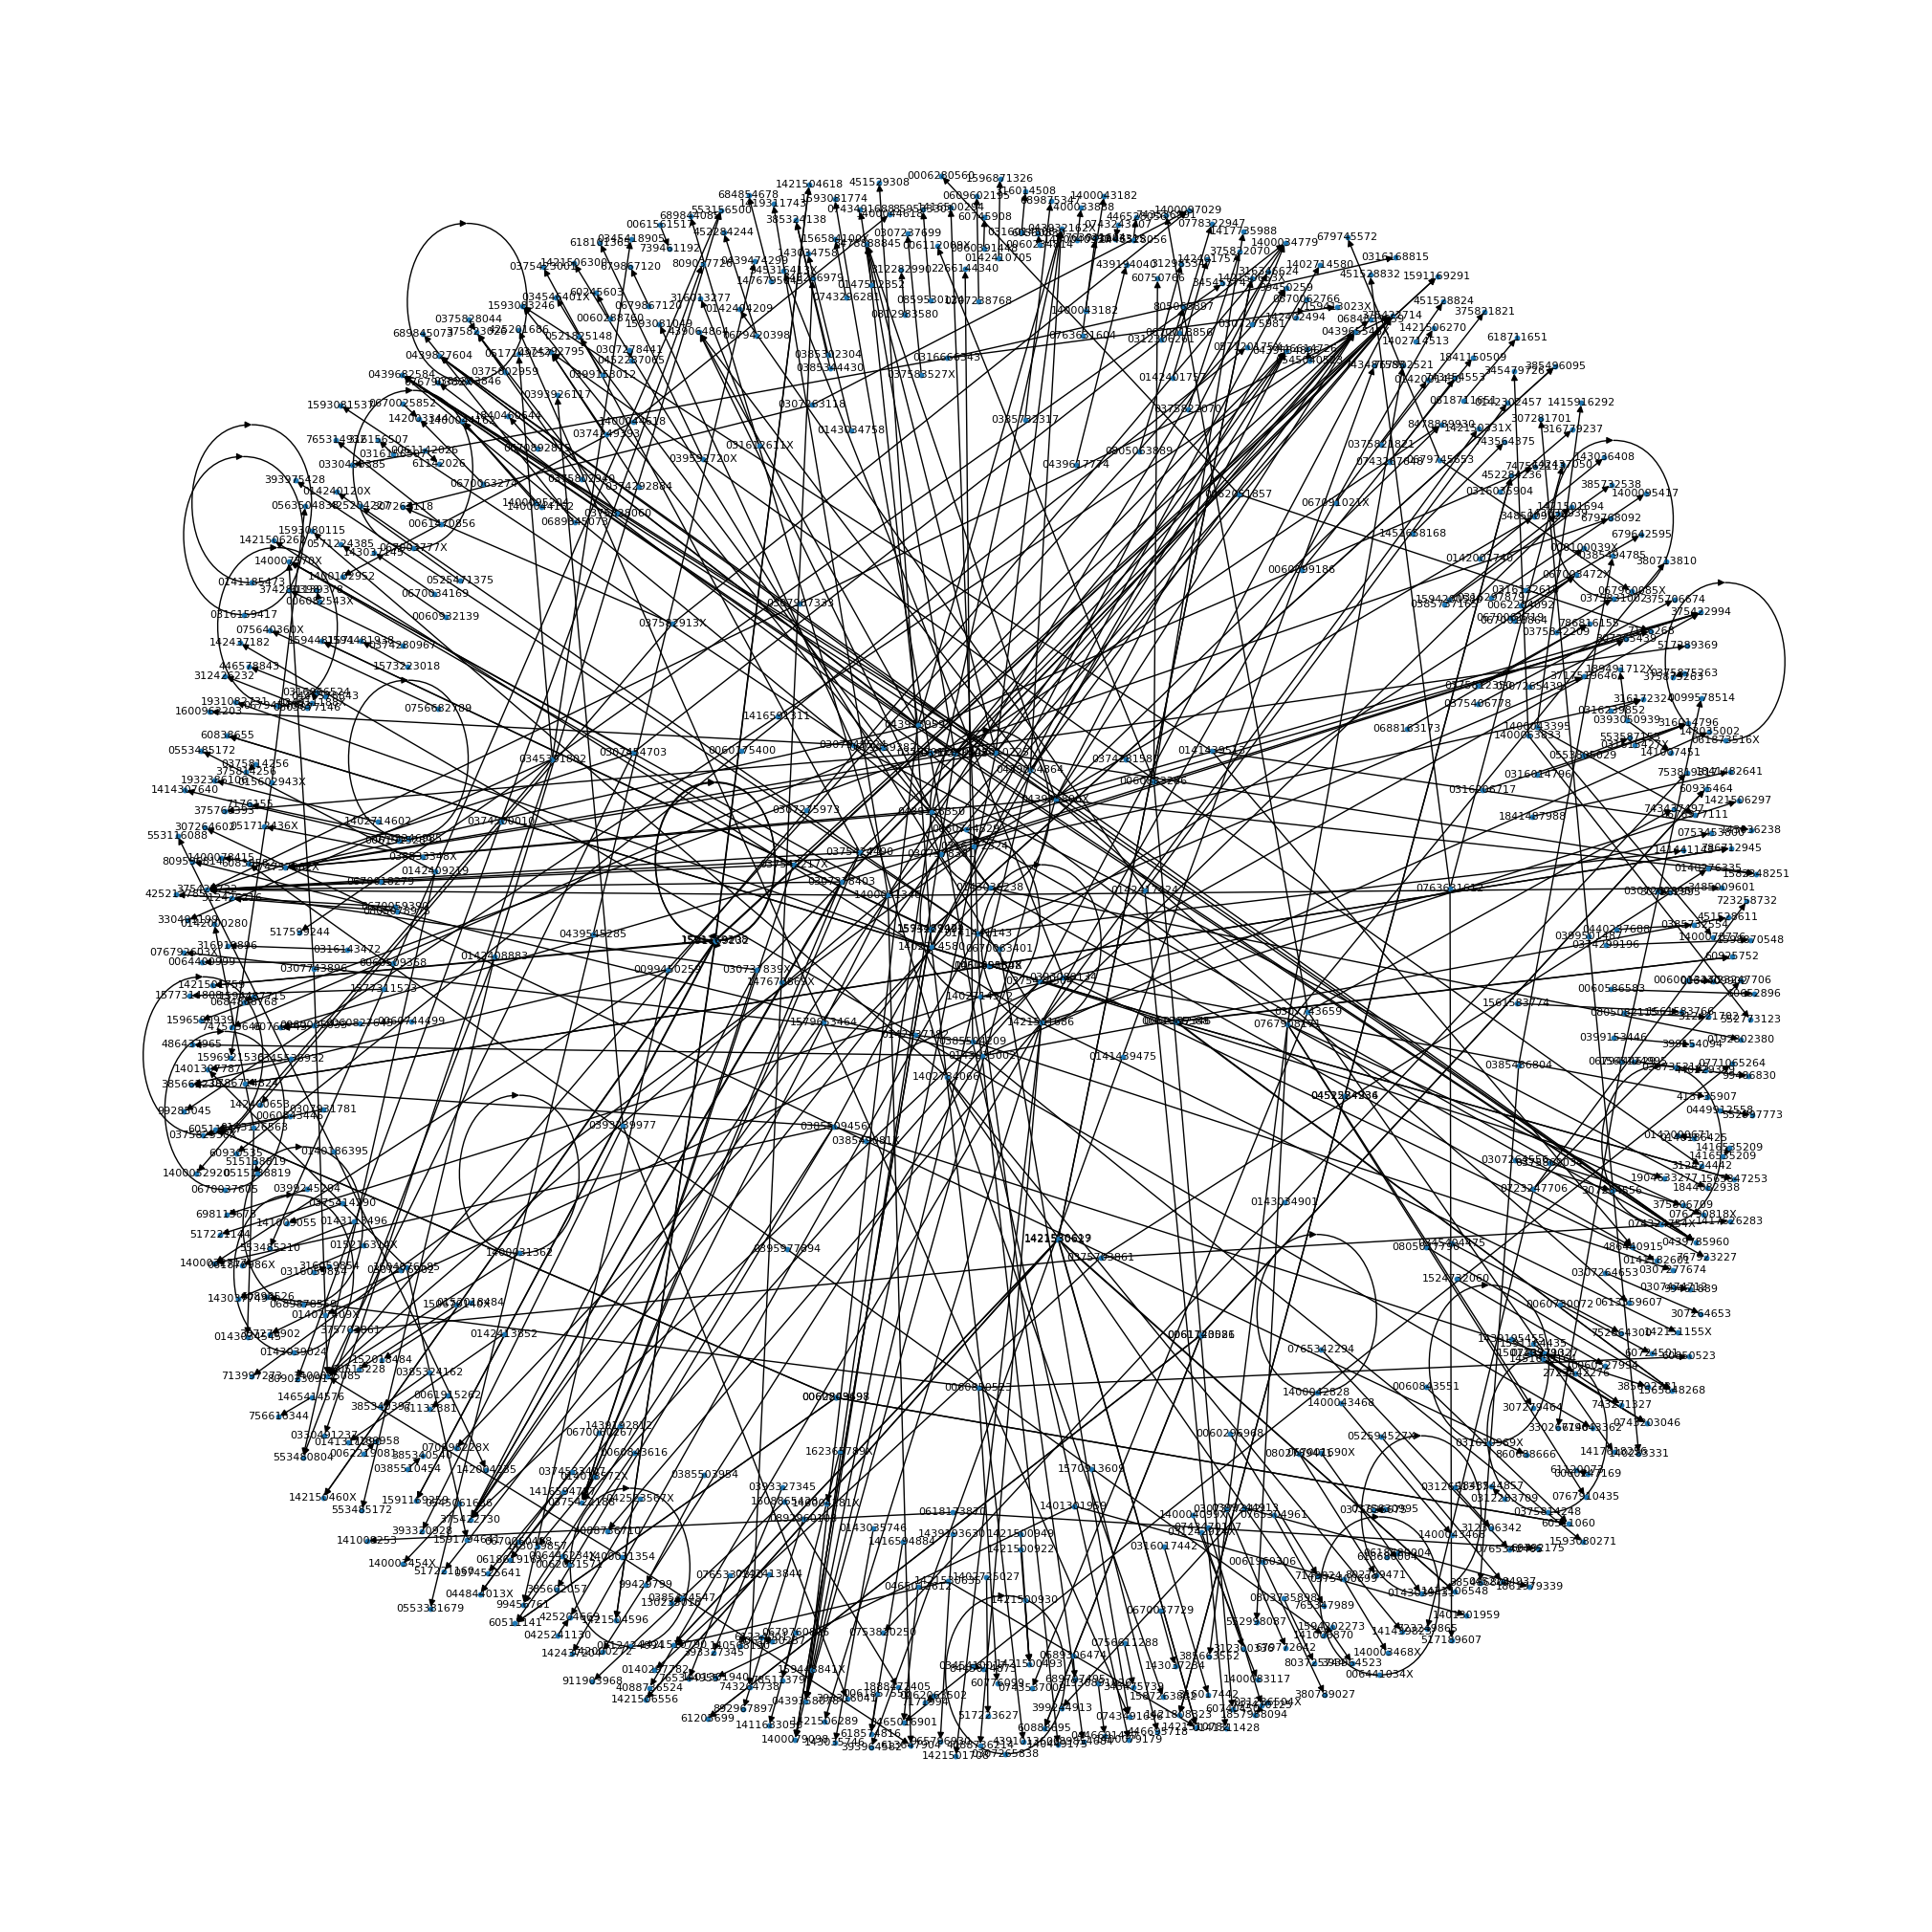

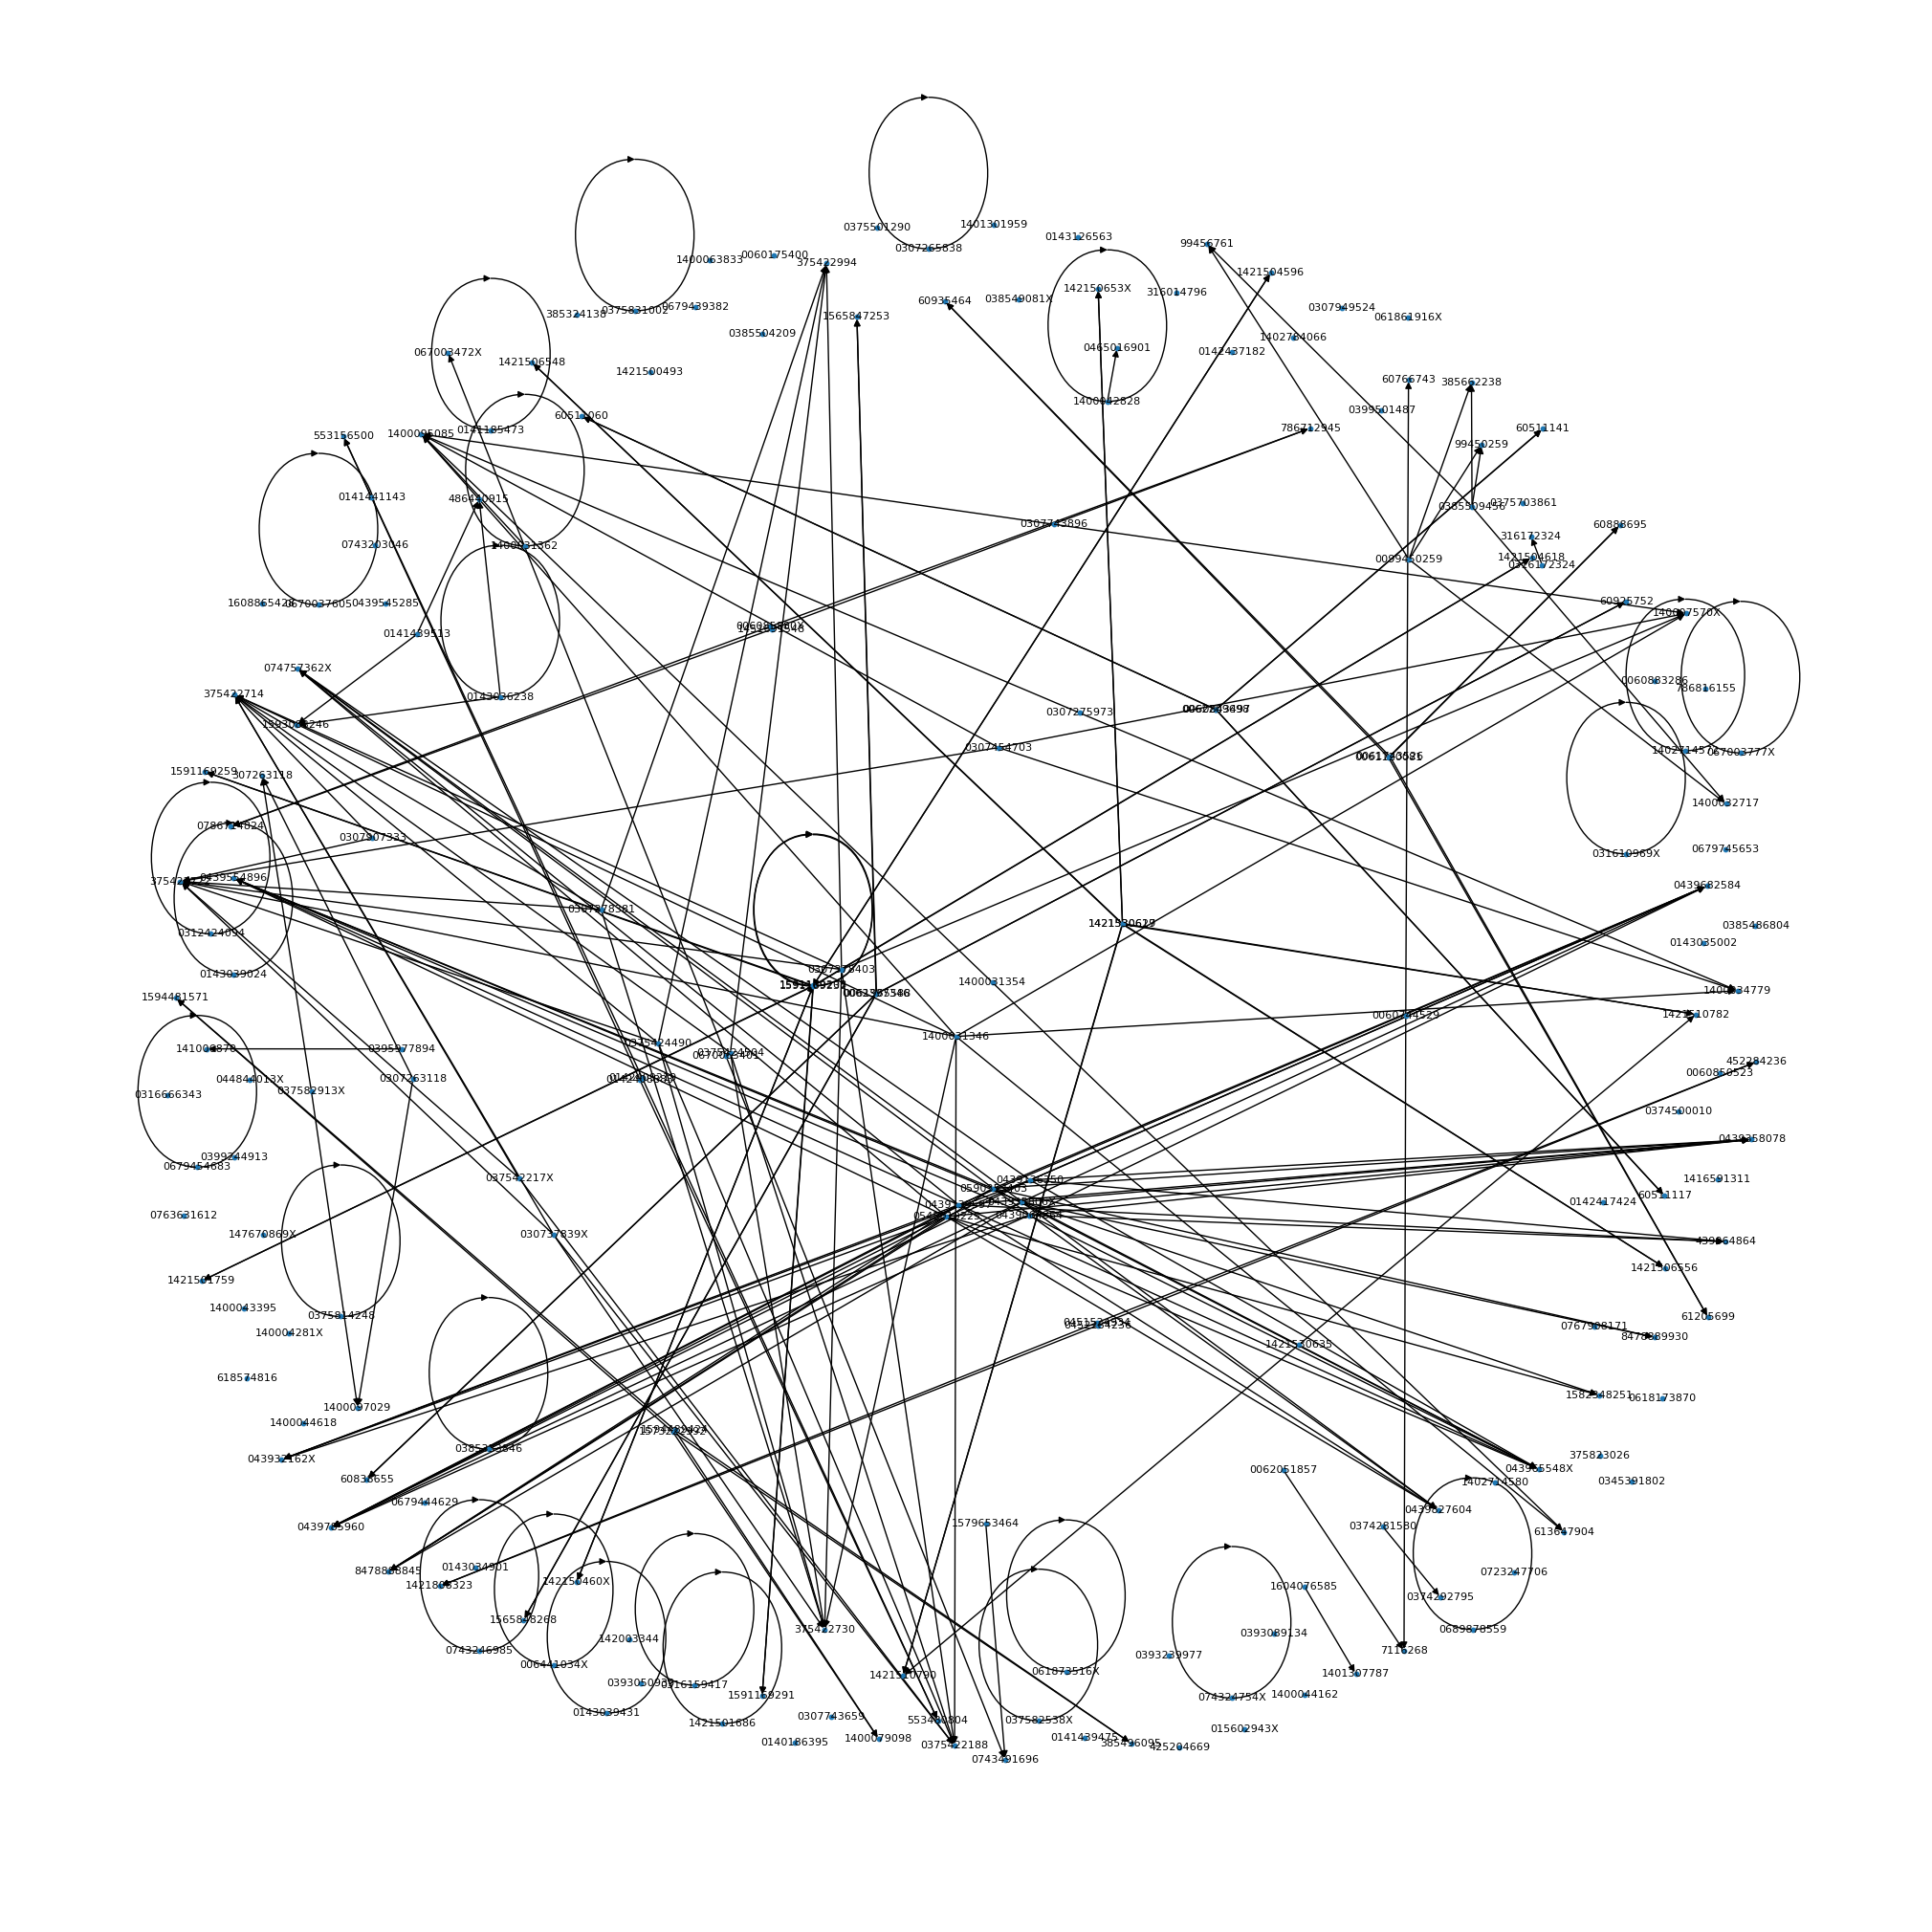

In [81]:
# We can view the isbn_map as a networkx graph.
# This allows us to see the connections between the two datasets.

import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(isbn_map, source = 'isbn_a', target = 'isbn_b', create_using = nx.DiGraph())
plt.figure(figsize=(20,20))
nx.draw(G, with_labels = True, node_size = 10, font_size = 8)
plt.show()

# Lets try again, but this time, let's untangle the graph.
# We'll do this by removing all the nodes that have a degree of 1.

G = nx.from_pandas_edgelist(isbn_map, source = 'isbn_a', target = 'isbn_b', create_using = nx.DiGraph())
G.remove_nodes_from([n for n, d in G.degree() if d == 1])
plt.figure(figsize=(20,20))
nx.draw(G, with_labels = True, node_size = 10, font_size = 8)
plt.show()

In [82]:
# Time to wrap this up.
# We're going to group our data by the isbn_b column, and send all the isbn_a's to a list.
isbn_map['isbn_b'] = isbn_map['isbn_b'].astype(str)
isbn_map = isbn_map.groupby('isbn_b')['isbn_a'].apply(list).reset_index(name = 'isbn_a')
# Prior to merging, we have to re-imput leading zeros.
isbn_map['isbn_b'] = isbn_map['isbn_b'].apply(lambda x: str(x).zfill(10))

# Finally, we'll just add back in the title and author columns.
isbn_map = pd.merge(isbn_map, goodreads, how = 'left', left_on = 'isbn_b', right_on = 'isbn')
isbn_map = isbn_map[['isbn_b', 'isbn_a', 'title', 'authors', 'publisher', 'Publication Year']]
isbn_map.columns = ['isbn_b', 'isbn_a', 'title', 'authors', 'publisher', 'publish_year']
isbn_map.head(3) # This is our final crosswalk.

isbn_b        isbn_a                                             title   
0  000100039X  [0316122610]                                       The Prophet  \
1  0006280560  [0062051857]                                 The Great Divorce   
2  0060527994  [1524732060]  The Devil and Miss Prym (On the Seventh Day  #3)   

                                      authors      publisher  publish_year  
0     Kahlil Gibran/جبران خليل جبران/Jihad El      Rupa & Co          2010  
1                                  C.S. Lewis  HarperCollins          2002  
2  Paulo Coelho/Amanda Hopkinson/Nick Caistor      HarperOne          2006

In [83]:
isbn_map.to_csv('cross_walk_data/crosswalk.csv', index = False)

# <b> SECTION 5: </b>
## OUR CONTRIBUTION BEYOND THE CROSSWALK: Exporting our Neural Network as a class

In [41]:
from joblib import dump

def train_neural_network(df : pd.DataFrame, dump_scaler = True, scaler_name = 'scaler') -> MLPClassifier:
    """Trains a neural network on the given dataframe"""
    y = df['is_match']
    X = df.drop(['is_match', 'isbn_a', 'isbn_b'], axis = 1)
    X_std = StandardScaler().fit(X).transform(X)
    if dump_scaler:
        dump(StandardScaler().fit(X), scaler_name + '.pkl')
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=42)

    print('Training Neural Network...')
    neural_grid ={'hidden_layer_sizes': [[10, 10], [5, 5], [15, 5]], 'activation': ['identity', 'logistic'], 'solver': ['lbfgs'], 'alpha': [.00001, .0001, .01], 'learning_rate': ['constant', 'invscaling', 'adaptive']}
    grid_search = GridSearchCV(MLPClassifier(),neural_grid,cv=5,return_train_score=True)
    neural_best=grid_search.fit(X_train,y_train)

    print("\tResults of Neural Net:")
    print("Best hidden layer size: ",neural_best.best_estimator_.get_params()['hidden_layer_sizes'])
    print("Best activation: ",neural_best.best_estimator_.get_params()['activation'])
    print("Best solver: ",neural_best.best_estimator_.get_params()['solver'])
    print("Best alpha: ",neural_best.best_estimator_.get_params()['alpha'])
    print("Best learning_rate: ",neural_best.best_estimator_.get_params()['learning_rate'])
    print("Accuracy on training set: {:.5f}".format(neural_best.score(X_train, y_train)))
    print("Accuracy on test set: {:.5f}".format(neural_best.score(X_test, y_test)))
    print("\n\n")

    return neural_best

In [27]:
# But wait! We might not have all the data every time we're interested in making a prediction. 
# Here are the following relevant scenarios:
# 1. We have the title, but not the author or publisher or publication date
# 2. We have the title and author, but not the publisher or publication date
# 3. We have the title and publisher, but not the author or publication date
# 4. We have the author and publisher and publication date, but not the title

In [28]:
title_only_df = subset_df[[col for col in list(subset_df.columns) if 'publish' not in col and 'author' not in col]].reset_index(drop = True)
title_author_df = subset_df[[col for col in list(subset_df.columns) if 'publish' not in col]].reset_index(drop = True)
title_publisher_df = subset_df[[col for col in list(subset_df.columns) if 'author' not in col and 'publish_year' not in col]].reset_index(drop = True)
author_publisher_df = subset_df[[col for col in list(subset_df.columns) if 'title' not in col]].reset_index(drop = True)

In [31]:
title_only_df

is_match      isbn_a      isbn_b  cleaned_title_levenshtein  \
0            1  074324754X  074324754X                          1   
1            1  0385537859  1101972971                         28   
2            1  030788743X  0307887448                          8   
3            1  0590353403  059035342X                          0   
4            1  1250012570  1250012570                          0   
...        ...         ...         ...                        ...   
5858         0  141690817X  0590846280                         22   
5859         0  0345479726  0385542690                         28   
5860         0  1250086612  0735212163                         23   
5861         0  0545298393  014241543X                         13   
5862         0  0375867643  0062392174                         19   

      cleaned_title_damerau  cleaned_title_hamming  cleaned_title_jaro  \
0                         1                      9            0.973846   
1                        28                     34            0.698214   
2                         8                      8            0.888889   
3                         0                      0            1.000000   
4                         0                      0            1.000000   
...                     ...                    ...                 ...   
5858                     22                     31            0.650277   
5859                     28                     36            0.534259   
5860                     23                     28            0.645743   
5861                     13                     15            0.562963   
5862                     19                     20            0.570048   

      cleaned_title_jaro_winkler  cleaned_title_lcs_seq_len  \
0                       0.984308                         25   
1                       0.698214                         14   
2                       0.933333                         16   
3                       1.000000                         36   
4                       1.000000                         13   
...                          ...                        ...   
5858                    0.650277                         15   
5859                    0.534259                          8   
5860                    0.645743                         11   
5861                    0.562963                          3   
5862                    0.570048                          9   

      cleaned_title_edit_dist  ...  removed_common_title_jaro_winkler  \
0                           1  ...                           1.000000   
1                          28  ...                           0.677382   
2                           8  ...                           0.947368   
3                           0  ...                           1.000000   
4                           0  ...                           1.000000   
...                       ...  ...                                ...   
5858                       22  ...                           0.428395   
5859                       28  ...                           0.498042   
5860                       23  ...                           0.517460   
5861                       13  ...                           0.417989   
5862                       19  ...                           0.550595   

      removed_common_title_lcs_seq_len  removed_common_title_edit_dist  \
0                                   17                               0   
1                                   11                              26   
2                                   14                               5   
3                                   25                               0   
4                                    8                               0   
...                                ...                             ...   
5858                                 5                              22   
5859                                 6                        

In [29]:
full_data_trained_network = train_neural_network(subset_df)
title_only_trained_network = train_neural_network(title_only_df)
title_author_trained_network = train_neural_network(title_author_df)
title_publisher_network = train_neural_network(title_publisher_df)
author_publisher_network = train_neural_network(author_publisher_df)

Training Neural Network...
	Results of Neural Net:
Best hidden layer size:  [5, 5]
Best activation:  logistic
Best solver:  lbfgs
Best alpha:  0.01
Best learning_rate:  invscaling
Accuracy on training set: 0.99909
Accuracy on test set: 0.99727



Training Neural Network...
	Results of Neural Net:
Best hidden layer size:  [15, 5]
Best activation:  identity
Best solver:  lbfgs
Best alpha:  1e-05
Best learning_rate:  adaptive
Accuracy on training set: 0.99886
Accuracy on test set: 0.99454



Training Neural Network...
	Results of Neural Net:
Best hidden layer size:  [5, 5]
Best activation:  logistic
Best solver:  lbfgs
Best alpha:  1e-05
Best learning_rate:  invscaling
Accuracy on training set: 0.99886
Accuracy on test set: 0.99659



Training Neural Network...
	Results of Neural Net:
Best hidden layer size:  [10, 10]
Best activation:  logistic
Best solver:  lbfgs
Best alpha:  0.01
Best learning_rate:  constant
Accuracy on training set: 0.99909
Accuracy on test set: 0.99727



Training Ne

In [30]:
# We would like to export the trained neural network so that we can use it for arbitrary OOS data.
# We can do this by using the pickle library.
# Let's save the full data trained network
with open('exported_models/full_data_trained_network.pkl', 'wb') as f:
    pickle.dump(full_data_trained_network, f)

with open('exported_models/title_only_trained_network.pkl', 'wb') as f:
    pickle.dump(title_only_trained_network, f)

# Let's save the title author trained network
with open('exported_models/title_author_trained_network.pkl', 'wb') as f:
    pickle.dump(title_author_trained_network, f)

# Let's save the title publisher trained network
with open('exported_models/title_publisher_trained_network.pkl', 'wb') as f:
    pickle.dump(title_publisher_network, f)

# Let's save the author publisher trained network
with open('exported_models/author_publisher_trained_network.pkl', 'wb') as f:
    pickle.dump(author_publisher_network, f)

* Please refer to Book_Comparer.py and book_comparer_test.ipynb

Thank you for taking the time to read this notebook.